In [1]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!pip install -q pyspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["PATH"] += ":/usr/lib/jvm/java-11-openjdk-amd64/bin"

In [3]:
import pyspark
sc = pyspark.SparkContext(appName="FraudDetection")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/18 02:14:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
from pyspark import SparkConf
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("FraudDetection") \
    .getOrCreate()

spark.sparkContext.getConf().getAll()
spark

In [126]:
import numpy as np 
import pandas as pd 
import json
import matplotlib.pyplot as plt
import warnings
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler,StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import avg, stddev, count, hour, col, max
from pyspark.ml import Pipeline
from sklearn.manifold import TSNE
import seaborn as sns
from pyspark.sql.functions import desc  # This line is essential for sorting
import json
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.ml.fpm import FPGrowth
import networkx as nx
from pyspark.sql.functions import hour, dayofweek, month, to_timestamp

warnings.filterwarnings("ignore")
data_path='/kaggle/input/transactions-data-big-data/Transactions Data/Transactions Data'

# Read the data

In [6]:
from pyspark.sql import functions as F

# Load the users data
users_df = spark.read.csv(f"{data_path}/users.csv", header=True, inferSchema=True)

# Remove '$' and ',' and cast the columns to double type
users_df = users_df.withColumn("per_capita_income", F.regexp_replace("per_capita_income", "[\$,]", "").cast("double"))
users_df = users_df.withColumn("yearly_income", F.regexp_replace("yearly_income", "[\$,]", "").cast("double"))
users_df = users_df.withColumn("total_debt", F.regexp_replace("total_debt", "[\$,]", "").cast("double"))

print(users_df.count())
# Check the count of rows
users_df.show(3)

1219
+---------+-----------+--------------+----------+-----------+------+-------------------+--------+---------+-----------------+-------------+----------+------------+----------------+
|client_id|current_age|retirement_age|birth_year|birth_month|gender|            address|latitude|longitude|per_capita_income|yearly_income|total_debt|credit_score|num_credit_cards|
+---------+-----------+--------------+----------+-----------+------+-------------------+--------+---------+-----------------+-------------+----------+------------+----------------+
|     1645|         62|            65|      1957|         11|Female|    58 Federal Lane|   41.47|   -81.85|          29692.0|      60541.0|  160456.0|         716|               3|
|     1591|         58|            66|      1961|          6|Female|   2200 Third Drive|   48.28|  -122.62|          16537.0|      33717.0|   58236.0|         698|               6|
|     1959|         46|            59|      1973|          4|  Male|8750 Lake Boulevard|  

In [129]:
from pyspark.sql import functions as F

# Read the transactions data
transactions_df = spark.read.csv(f"{data_path}/transactions.csv", header=True, inferSchema=True)

# Remove '$' and ',' and cast the 'amount' column to double type
transactions_df = transactions_df.withColumn("amount", F.regexp_replace("amount", "[\$,]", "").cast("double"))

# Check the count of rows
print(transactions_df.count())
transactions_df.show(3)

8914963
+-------+-------------------+---------+-------+------+-----------------+-----------+---------------+----+--------+------+
|     id|               date|client_id|card_id|amount|         use_chip|merchant_id|  merchant_city| mcc|  errors|target|
+-------+-------------------+---------+-------+------+-----------------+-----------+---------------+----+--------+------+
|7475341|2010-01-01 00:27:00|     1797|   1127| 43.33|Swipe Transaction|      33326|        Kahului|4121|No Error|    No|
|7475347|2010-01-01 00:36:00|      114|   3398| -64.0|Swipe Transaction|      61195|North Hollywood|5541|No Error|    No|
|7475378|2010-01-01 01:19:00|     1575|   2112| 17.14|Swipe Transaction|      29232|         Osprey|4121|No Error|    No|
+-------+-------------------+---------+-------+------+-----------------+-----------+---------------+----+--------+------+
only showing top 3 rows



In [9]:
# Read the cards data
cards_df = spark.read.csv(f"{data_path}/cards.csv", header=True, inferSchema=True)

# Remove '$' and ',' and cast the 'credit_limit' column to double type
cards_df = cards_df.withColumn("credit_limit", F.regexp_replace("credit_limit", "[\$,]", "").cast("double"))

# Check the count of rows
cards_df.count()

4514

# EDA

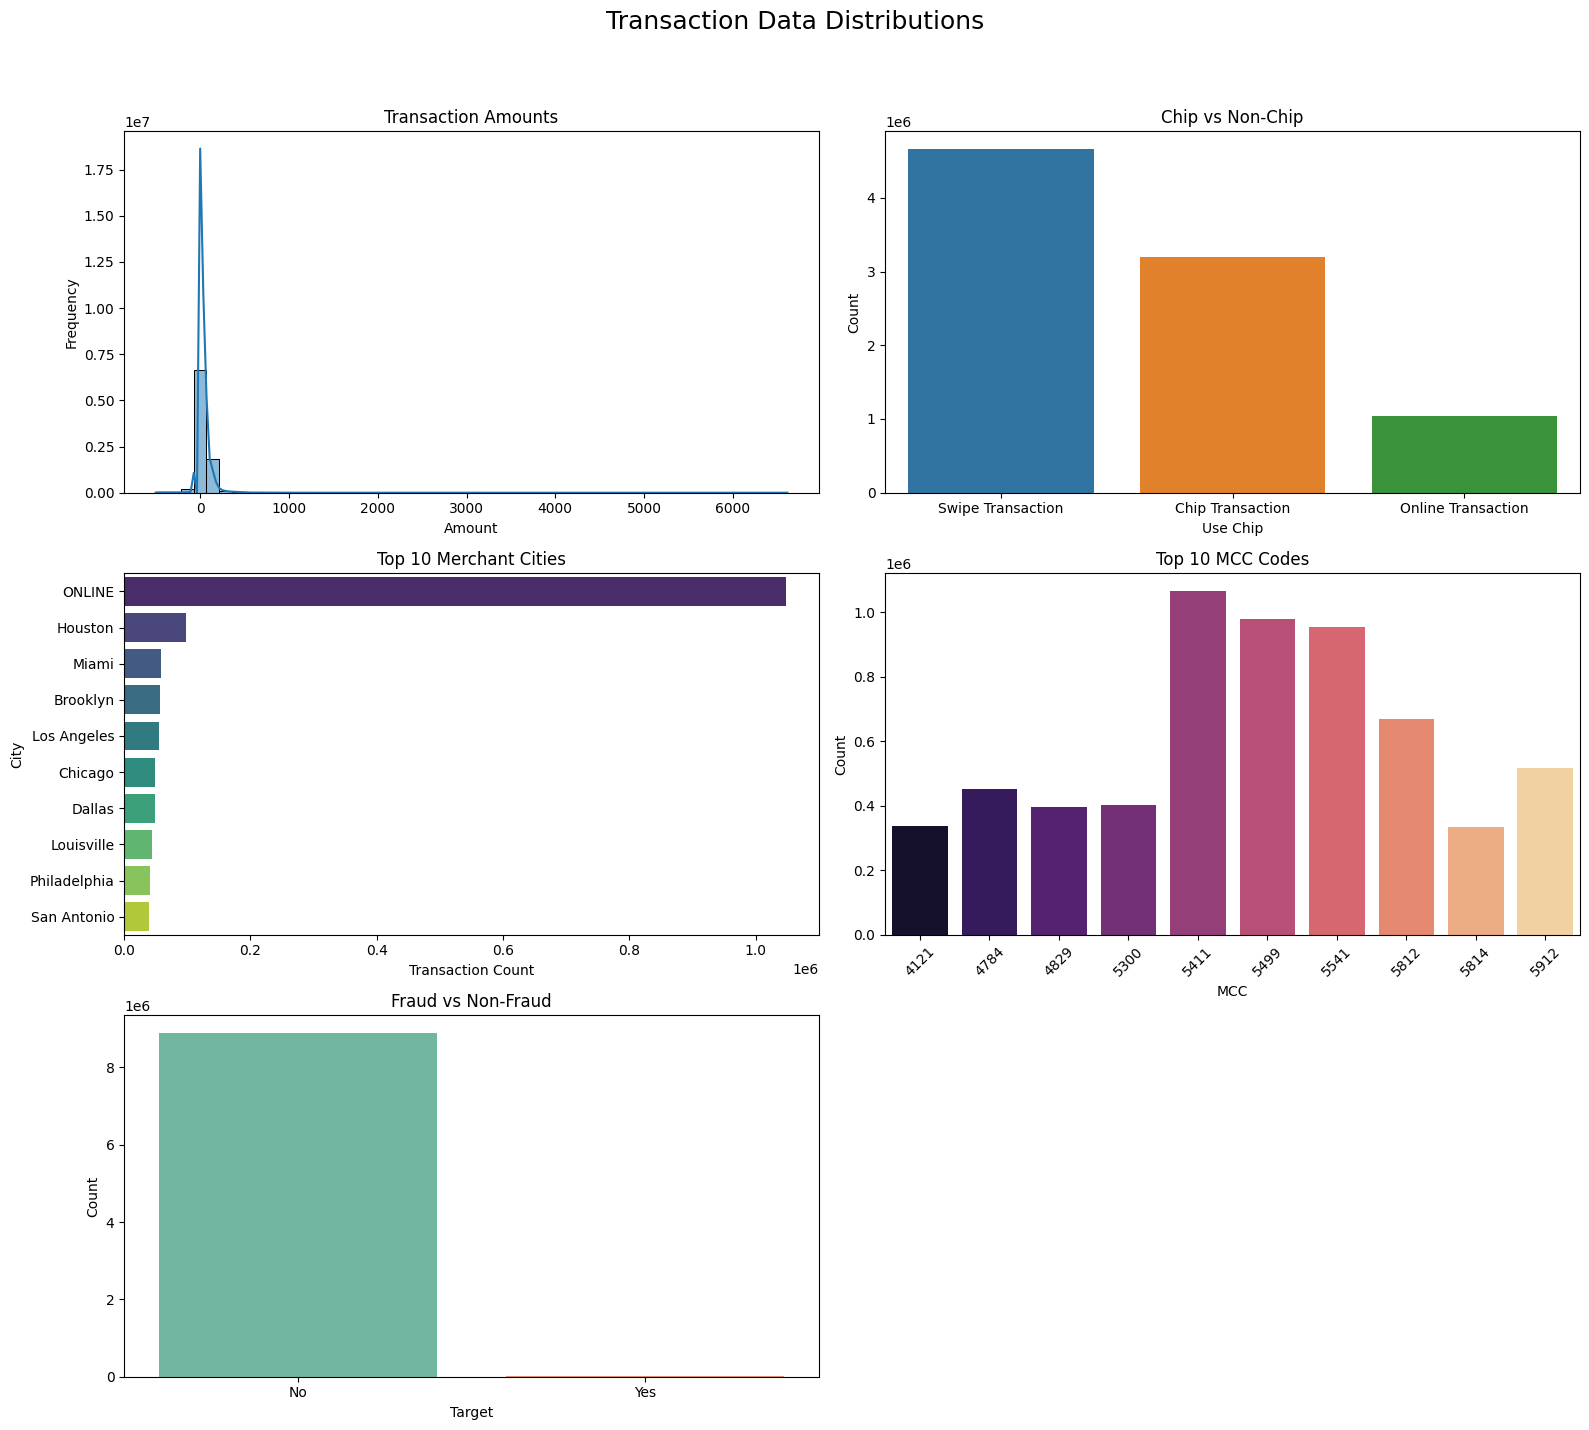

In [125]:


# Convert required PySpark DataFrames to pandas
amount_df = transactions_df.select("amount").toPandas()
chip_df = transactions_df.groupBy("use_chip").count().toPandas()
top_cities = transactions_df.groupBy("merchant_city").count().orderBy("count", ascending=False).limit(10).toPandas()
mcc_df = transactions_df.groupBy("mcc").count().orderBy("count", ascending=False).limit(10).toPandas()
target_df = transactions_df.groupBy("target").count().toPandas()

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 15))
fig.suptitle('Transaction Data Distributions', fontsize=18)

# 1. Distribution of Amounts
sns.histplot(amount_df["amount"], bins=50, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Transaction Amounts")
axes[0, 0].set_xlabel("Amount")
axes[0, 0].set_ylabel("Frequency")

# 2. Use Chip vs No
sns.barplot(data=chip_df, x="use_chip", y="count", ax=axes[0, 1])
axes[0, 1].set_title("Chip vs Non-Chip")
axes[0, 1].set_xlabel("Use Chip")
axes[0, 1].set_ylabel("Count")

# 3. Top 10 Merchant Cities
sns.barplot(data=top_cities, x="count", y="merchant_city", palette="viridis", ax=axes[1, 0])
axes[1, 0].set_title("Top 10 Merchant Cities")
axes[1, 0].set_xlabel("Transaction Count")
axes[1, 0].set_ylabel("City")

# 4. Top 10 MCC Codes
sns.barplot(data=mcc_df, x="mcc", y="count", palette="magma", ax=axes[1, 1])
axes[1, 1].set_title("Top 10 MCC Codes")
axes[1, 1].set_xlabel("MCC")
axes[1, 1].set_ylabel("Count")
axes[1, 1].tick_params(axis='x', rotation=45)

# 5. Fraud vs Non-Fraud
sns.barplot(data=target_df, x="target", y="count", palette="Set2", ax=axes[2, 0])
axes[2, 0].set_title("Fraud vs Non-Fraud")
axes[2, 0].set_xlabel("Target")
axes[2, 0].set_ylabel("Count")

# Hide the unused 6th plot (bottom-right)
axes[2, 1].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Analysis of Common Transaction Types 

In [32]:
with open("/kaggle/input/transactions-data-big-data/mcc_codes.json", "r") as f:
    mcc_dict = json.load(f)

# Convert to list of dicts
mcc_list = [{"mcc": int(k), "description": v} for k, v in mcc_dict.items()]

# Create Spark DataFrame
mcc_df = spark.createDataFrame(mcc_list)
mcc_df.printSchema()
transactions_df.printSchema()

transactions_df = transactions_df.join(mcc_df, on="mcc", how="left")

root
 |-- description: string (nullable = true)
 |-- mcc: long (nullable = true)

root
 |-- id: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- client_id: integer (nullable = true)
 |-- card_id: integer (nullable = true)
 |-- amount: double (nullable = true)
 |-- use_chip: string (nullable = true)
 |-- merchant_id: integer (nullable = true)
 |-- merchant_city: string (nullable = true)
 |-- mcc: integer (nullable = true)
 |-- errors: string (nullable = true)
 |-- target: string (nullable = true)



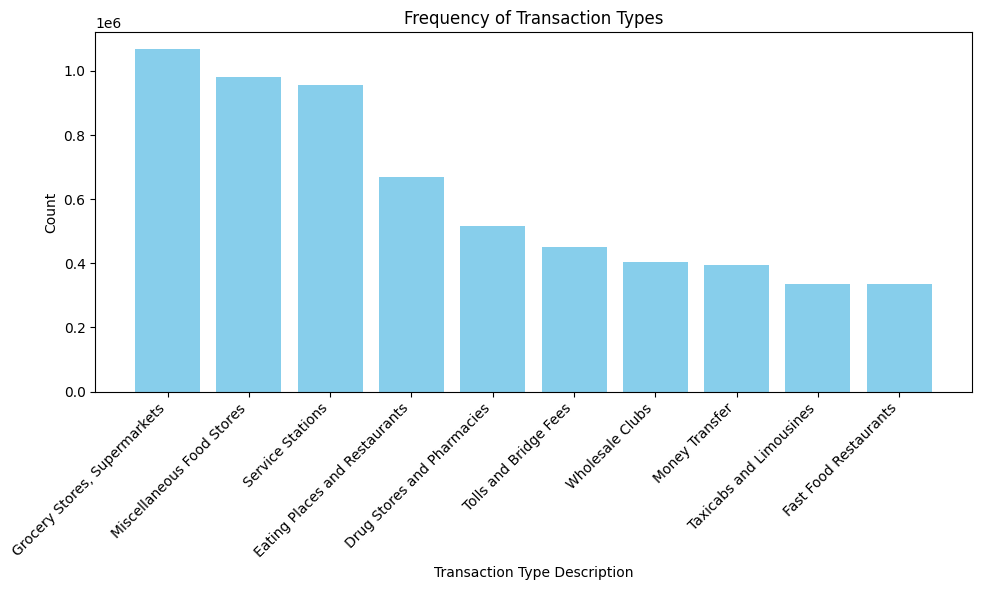

In [42]:

transaction_type_counts = transactions_df.groupBy("description").count()

#  Sort to find the most frequent transaction types
sorted_types = transaction_type_counts.orderBy(desc("count")).limit(10)
pandas_df = sorted_types.toPandas()

# Histogram (Bar Chart)
plt.figure(figsize=(10, 6))
plt.bar(pandas_df['description'], pandas_df['count'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Transaction Type Description")
plt.ylabel("Count")
plt.title("Frequency of Transaction Types")
plt.tight_layout()
plt.show()


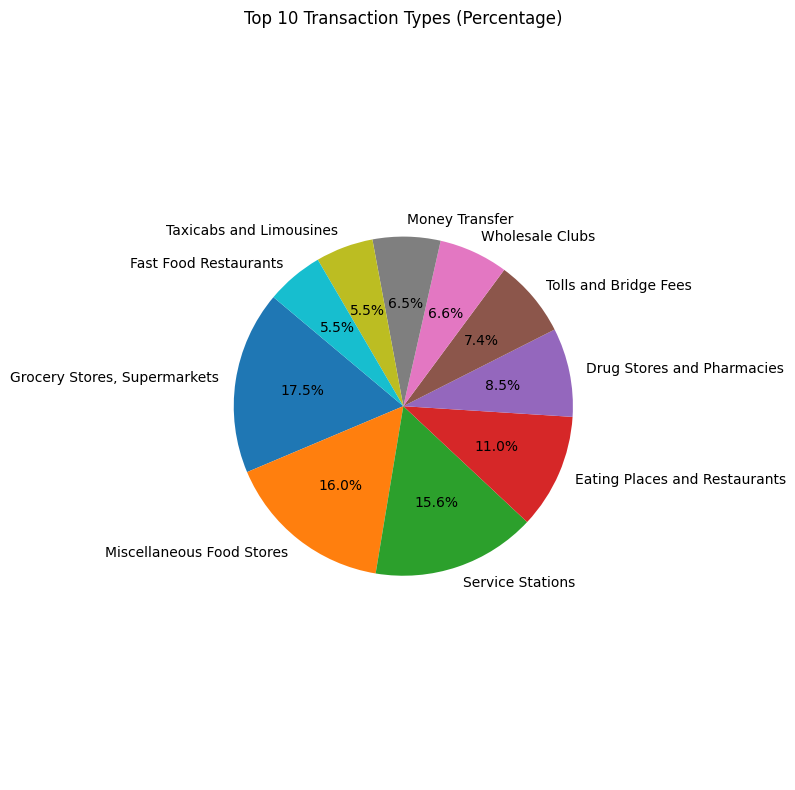

In [41]:
# Pie chart
plt.figure(figsize=(8, 8))
plt.pie(pandas_df['count'], labels=pandas_df['description'], autopct='%1.1f%%', startangle=140)
plt.title("Top 10 Transaction Types (Percentage)")
plt.axis('equal')  # Equal aspect ratio ensures a circle.
plt.tight_layout()
plt.show()

In [54]:
sorted_types.printSchema()

root
 |-- description: string (nullable = true)
 |-- count: long (nullable = false)



In [57]:
##find which transcation types are more likely to be fraudulent.

# Get total count and fraud count per transaction type
transaction_fraud_stats = transactions_df.filter("target == 'Yes'") \
    .groupBy("description") \
    .agg(
        F.count("*").alias("fraud_count")
    )


In [60]:

# transaction_fraud_stats.show()
# Calculate fraud rate without join
transaction_with_fraud_rate = sorted_types.join(transaction_fraud_stats, on="description", how="left") \
    .withColumn("fraud_rate", F.col("fraud_count") / F.col("count")*100).orderBy(desc("fraud_rate"))

# Show sorted results by fraud rate
print("fraud rate in top 10 transcation types")
transaction_with_fraud_rate.orderBy(F.desc("fraud_rate")).show()

fraud rate in top 10 transcation types


+--------------------+-------+-----------+--------------------+
|         description|  count|fraud_count|          fraud_rate|
+--------------------+-------+-----------+--------------------+
|     Wholesale Clubs| 403343|        991| 0.24569659074286648|
|      Money Transfer| 394401|        725| 0.18382306332894693|
|Drug Stores and P...| 517400|        479| 0.09257827599536142|
|Taxicabs and Limo...| 335586|        300| 0.08939586275947149|
|Fast Food Restaur...| 334333|        235|  0.0702892026811592|
|Grocery Stores, S...|1066833|        425| 0.03983753783394402|
|Eating Places and...| 669808|        121|0.018064878293481117|
|    Service Stations| 955123|        168|  0.0175893576010629|
|Miscellaneous Foo...| 979396|        131|0.013375590670168145|
|Tolls and Bridge ...| 451814|       NULL|                NULL|
+--------------------+-------+-----------+--------------------+



In [61]:
transaction_with_fraud_rate = transaction_type_counts.join(transaction_fraud_stats, on="description", how="left") \
    .withColumn("fraud_rate", F.col("fraud_count") / F.col("count")*100).orderBy(desc("fraud_rate")).limit(10)

print("Most common types with fraud transcations")
transaction_with_fraud_rate.orderBy(F.desc("fraud_rate")).show()



top 10 transcation types with fraud rates


+--------------------+-----+-----------+------------------+
|         description|count|fraud_count|        fraud_rate|
+--------------------+-----+-----------+------------------+
|        Cruise Lines|  276|        165| 59.78260869565217|
|Music Stores - Mu...|  204|         76|37.254901960784316|
|Miscellaneous Fab...|  245|         29| 11.83673469387755|
|Computers, Comput...| 1883|        204|10.833775889537971|
|Floor Covering St...|  222|         23| 10.36036036036036|
|Miscellaneous Met...|  256|         22|           8.59375|
|  Electronics Stores| 4689|        402| 8.573256557901471|
|Fabricated Struct...|  273|         22| 8.058608058608058|
|Precious Stones a...| 3525|        242| 6.865248226950355|
|Furniture, Home F...| 2600|        170| 6.538461538461539|
+--------------------+-----+-----------+------------------+



# Association of Transaction Features

In [119]:
from pyspark.sql import functions as F
from pyspark.ml.fpm import FPGrowth

# Step 1: Bin the amount into categorical strings
transactions_fpgrowth_data = transactions_df.withColumn(
    "amount_flag", 
    F.when(F.col("amount") > 100, F.lit("amount>100"))
     .otherwise(F.lit("amount<=100"))
)

# Step 2: Select the relevant columns
transactions_fpgrowth_data = transactions_fpgrowth_data.select(
    "description", "merchant_city", "amount_flag"
)

# Step 3: Assemble the features array
transactions_fpgrowth_data = transactions_fpgrowth_data.withColumn(
    "features", 
    F.array("description", "merchant_city", "amount_flag")
)

# Step 4: Run FP-Growth
fpgrowth = FPGrowth(itemsCol="features", minSupport=0.01, minConfidence=0.1)
model = fpgrowth.fit(transactions_fpgrowth_data)


25/04/18 04:43:46 WARN MemoryStore: Not enough space to cache rdd_1158_2 in memory! (computed 101.1 MiB so far)
25/04/18 04:43:46 WARN BlockManager: Persisting block rdd_1158_2 to disk instead.
25/04/18 04:43:46 WARN MemoryStore: Not enough space to cache rdd_1158_3 in memory! (computed 99.7 MiB so far)
25/04/18 04:43:46 WARN BlockManager: Persisting block rdd_1158_3 to disk instead.
25/04/18 04:43:46 WARN MemoryStore: Not enough space to cache rdd_1158_1 in memory! (computed 100.7 MiB so far)
25/04/18 04:43:46 WARN BlockManager: Persisting block rdd_1158_1 to disk instead.
25/04/18 04:43:46 WARN MemoryStore: Not enough space to cache rdd_1158_0 in memory! (computed 100.2 MiB so far)
25/04/18 04:43:46 WARN BlockManager: Persisting block rdd_1158_0 to disk instead.
25/04/18 04:43:54 WARN MemoryStore: Not enough space to cache rdd_1158_1 in memory! (computed 44.8 MiB so far)
25/04/18 04:43:55 WARN MemoryStore: Not enough space to cache rdd_1158_0 in memory! (computed 44.5 MiB so far)
25/

In [120]:
# Get the frequent itemsets 
frequent_itemsets = model.freqItemsets

frequent_itemsets.show(truncate=False)

#  Generate association rules from the frequent itemsets
association_rules = model.associationRules

# Show the association rules
association_rules.show(truncate=False)


+----------------------------------------------------+-------+
|items                                               |freq   |
+----------------------------------------------------+-------+
|[Lumber and Building Materials]                     |116303 |
|[Lumber and Building Materials, amount<=100]        |112206 |
|[Service Stations]                                  |955123 |
|[Service Stations, amount<=100]                     |916219 |
|[Money Transfer]                                    |394401 |
|[Money Transfer, amount>100]                        |112360 |
|[Money Transfer, amount<=100]                       |282041 |
|[Drinking Places (Alcoholic Beverages)]             |166460 |
|[Drinking Places (Alcoholic Beverages), amount<=100]|166257 |
|[amount<=100]                                       |7956759|
|[Taxicabs and Limousines]                           |335586 |
|[Taxicabs and Limousines, ONLINE]                   |195828 |
|[Taxicabs and Limousines, ONLINE, amount<=100]      |1

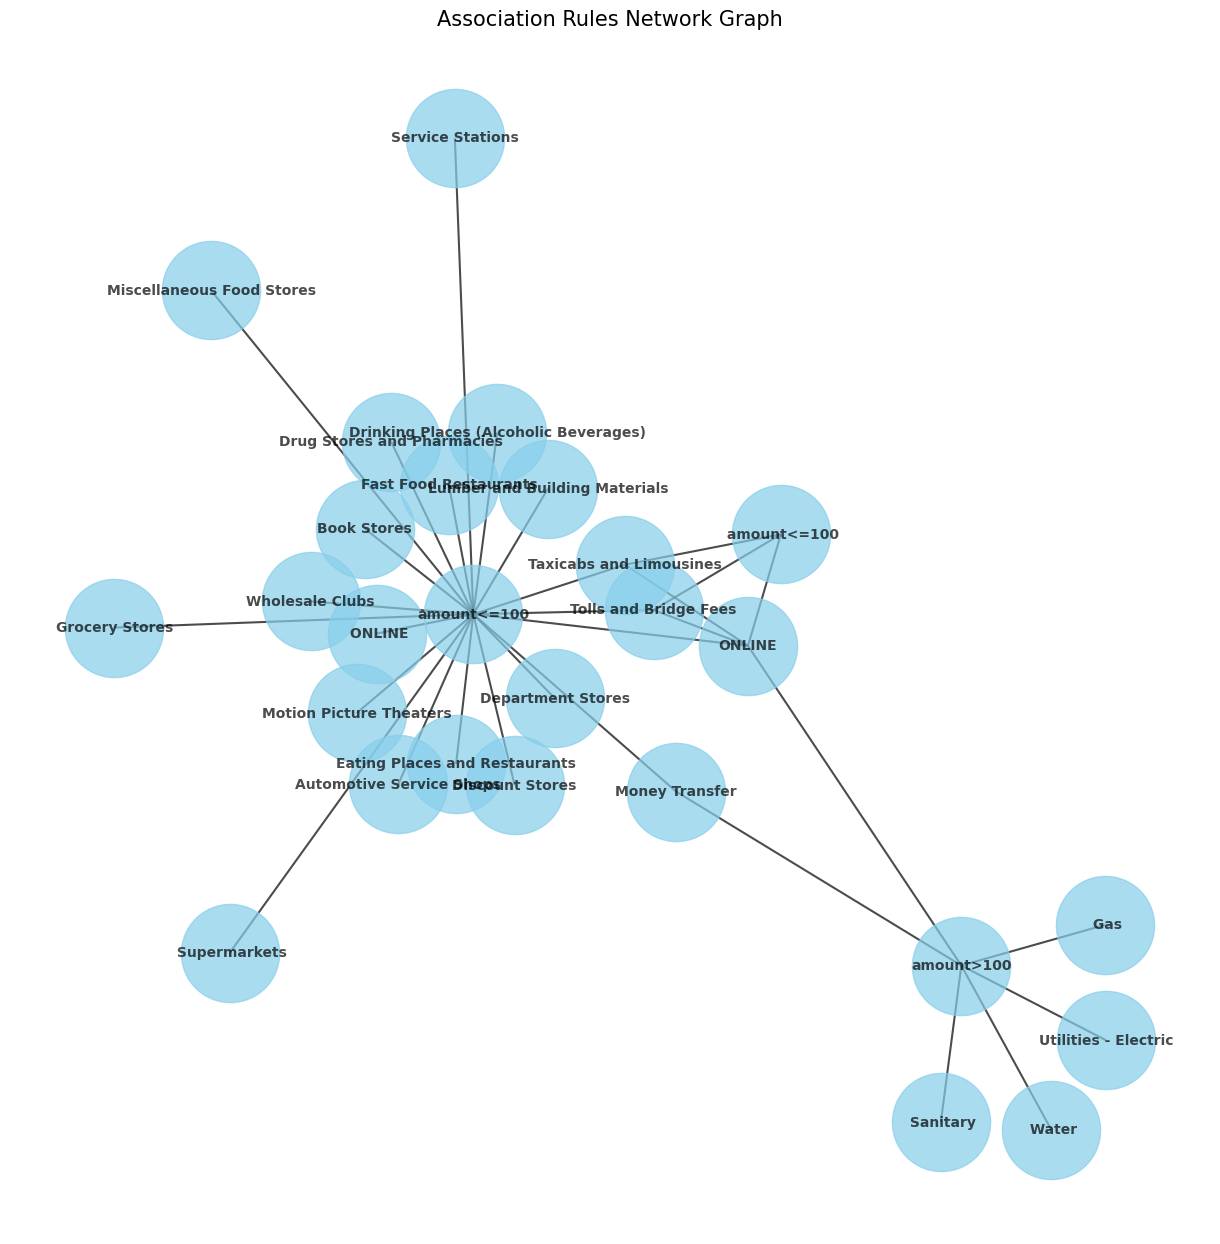

In [121]:
association_rules_df = association_rules.toPandas()

# Assuming association_rules DataFrame is loaded with 'antecedent', 'consequent', 'support', 'confidence', 'lift'
# Convert antecedent and consequent into list of items
association_rules_df['antecedent'] = association_rules_df['antecedent'].apply(lambda x: str(x).replace('[','').replace(']','').replace("'",'').split(","))
association_rules_df['consequent'] = association_rules_df['consequent'].apply(lambda x: str(x).replace('[','').replace(']','').replace("'",'').split(","))

# Initialize a graph
G = nx.Graph()

# Add edges with weights (support, confidence, or lift)
for idx, row in association_rules_df.iterrows():
    for antecedent_item in row['antecedent']:
        for consequent_item in row['consequent']:
            G.add_edge(antecedent_item, consequent_item, weight=row['confidence'])

# Draw the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)  # Position the nodes
nx.draw(G, pos, with_labels=True, node_size=5000, node_color='skyblue', font_size=10, font_weight='bold', width=1.5, alpha=0.7)
plt.title('Association Rules Network Graph', fontsize=15)
plt.show()


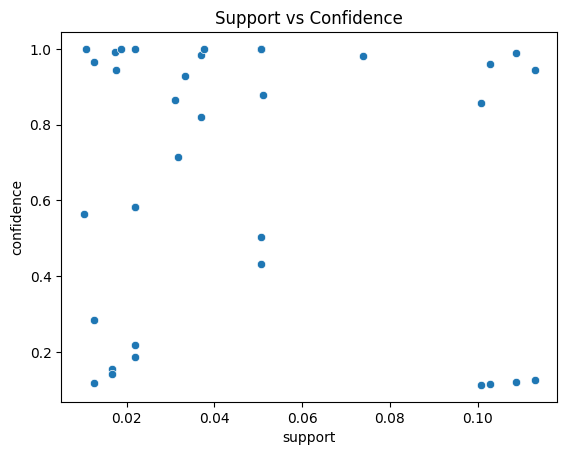

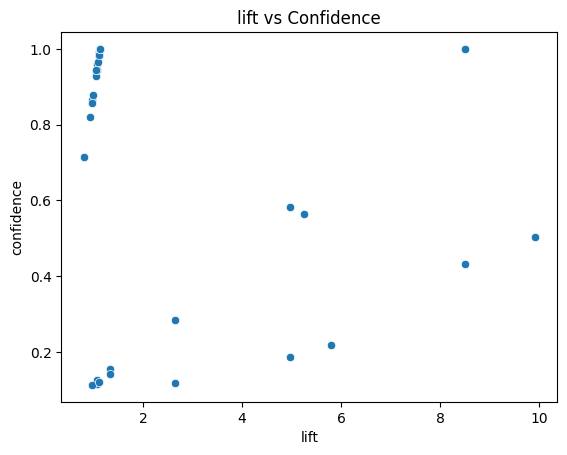

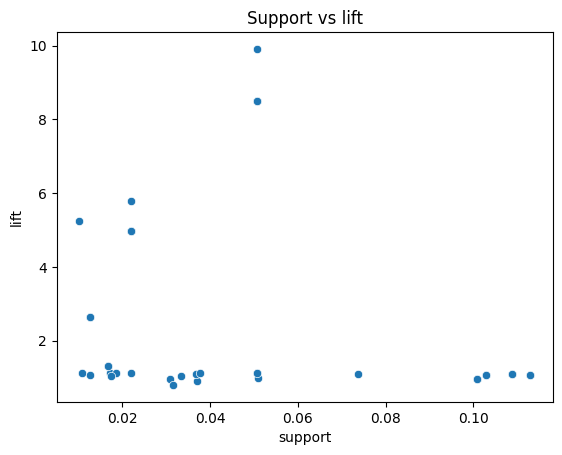

In [123]:

# Create a DataFrame for plotting
# association_rules_df = pd.DataFrame(association_rules)

sns.scatterplot(data=association_rules_df, x='support', y='confidence')
plt.title("Support vs Confidence")
plt.show()

sns.scatterplot(data=association_rules_df, x='lift', y='confidence')
plt.title("lift vs Confidence")
plt.show()

sns.scatterplot(data=association_rules_df, x='support', y='lift')
plt.title("Support vs lift")
plt.show()


- most rules have high confidence but low support meaning they are reliable but apply to small portion of total transcations


# Time-Based Transaction Behavior Analysis 

In [131]:

# Extract time features
transactions_df1 = transactions_df.withColumn("hour", hour("date"))
transactions_df1 = transactions_df1.withColumn("day_of_week", dayofweek("date"))  # 1 = Sunday, 7 = Saturday
transactions_df1 = transactions_df1.withColumn("month", month("date"))
transactions_df1.show(10)

+-------+-------------------+---------+-------+------+------------------+-----------+---------------+----+--------+------+----+-----------+-----+
|     id|               date|client_id|card_id|amount|          use_chip|merchant_id|  merchant_city| mcc|  errors|target|hour|day_of_week|month|
+-------+-------------------+---------+-------+------+------------------+-----------+---------------+----+--------+------+----+-----------+-----+
|7475341|2010-01-01 00:27:00|     1797|   1127| 43.33| Swipe Transaction|      33326|        Kahului|4121|No Error|    No|   0|          6|    1|
|7475347|2010-01-01 00:36:00|      114|   3398| -64.0| Swipe Transaction|      61195|North Hollywood|5541|No Error|    No|   0|          6|    1|
|7475378|2010-01-01 01:19:00|     1575|   2112| 17.14| Swipe Transaction|      29232|         Osprey|4121|No Error|    No|   1|          6|    1|
|7475398|2010-01-01 01:53:00|       63|     60| 30.69| Swipe Transaction|      32175|         Newark|7538|No Error|    No|  

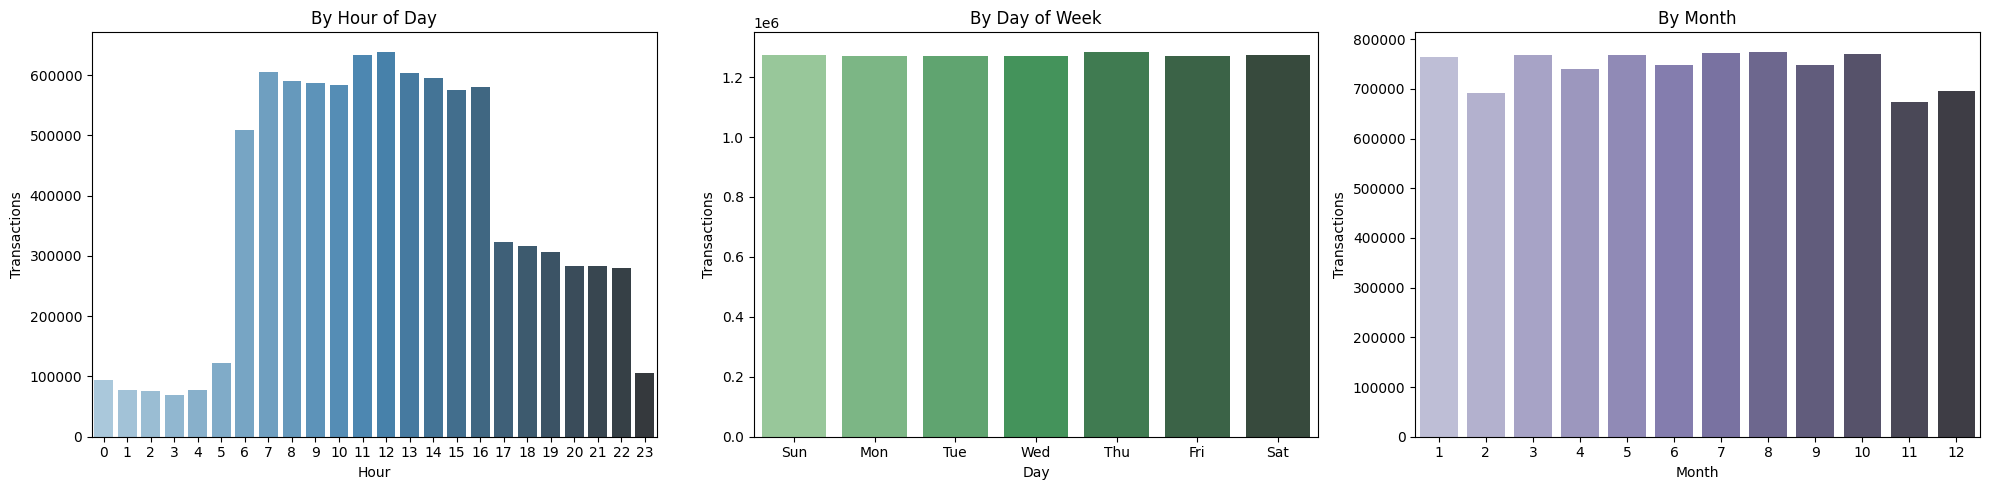

In [135]:
hour_df = transactions_df1.groupBy("hour").count().orderBy("hour").toPandas()
day_df = transactions_df1.groupBy("day_of_week").count().orderBy("day_of_week").toPandas()
month_df = transactions_df1.groupBy("month").count().orderBy("month").toPandas()

day_labels = {1: 'Sun', 2: 'Mon', 3: 'Tue', 4: 'Wed', 5: 'Thu', 6: 'Fri', 7: 'Sat'}
day_df["day_name"] = day_df["day_of_week"].map(day_labels)

fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Hour of day
sns.barplot(data=hour_df, x="hour", y="count", ax=axs[0], palette="Blues_d")
axs[0].set_title("By Hour of Day")
axs[0].set_xlabel("Hour")
axs[0].set_ylabel("Transactions")

# Day of week
sns.barplot(data=day_df, x="day_name", y="count", ax=axs[1], palette="Greens_d")
axs[1].set_title("By Day of Week")
axs[1].set_xlabel("Day")
axs[1].set_ylabel("Transactions")

# Month
sns.barplot(data=month_df, x="month", y="count", ax=axs[2], palette="Purples_d")
axs[2].set_title("By Month")
axs[2].set_xlabel("Month")
axs[2].set_ylabel("Transactions")

plt.tight_layout()
plt.show()